Be sure to run the following notebook first before running this notebook:
- 1-load-and-convert-statsbomb-data.ipynb

In [1]:
import os
import tqdm
import pandas as pd
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2
import socceraction.spadl as spadl
import socceraction.vaep.features as fs
import socceraction.xthreat as xthreat

## Select data

In [3]:
# Configure file and folder names, use SPADL format.
datafolder = "../data-fifa"
spadl_h5 = os.path.join(datafolder, "spadl-statsbomb.h5")
xT_h5 = os.path.join(datafolder, "xT.h5")

In [4]:
games = pd.read_hdf(spadl_h5, "games")
print("nb of games:", len(games))

nb of games: 64


In [5]:
# Read in all actions of games
A = []

with pd.HDFStore(spadl_h5) as spadlstore:
    for game in tqdm.tqdm(list(games.itertuples())):
        actions = spadlstore[f"actions/game_{game.game_id}"]
        actions = spadl.add_names(actions)
        actions = spadl.play_left_to_right(actions, game.home_team_id)
        A.append(actions) 

A = pd.concat(A)

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:02<00:00, 28.53it/s]


## Load pre-trained model

In [6]:
# uncomment the lines below if you get an SSLError
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

url_grid = "https://karun.in/blog/data/open_xt_12x8_v1.json"
xTModel = xthreat.load_model(url_grid)

## Train a custom model

In [7]:
xTModel = xthreat.ExpectedThreat(l=16, w=12)
xTModel.fit(A);

# iterations:  45


## Compute xT ratings

In [8]:
## Predict

# xT should only be used to value actions that move the ball 
# and also keep the current team in possession of the ball
mov_actions = xthreat.get_successful_move_actions(A)
mov_actions["xT_value"] = xTModel.rate(mov_actions)
mov_actions[["type_name", "start_x", "start_y", "end_x", "end_y", "xT_value"]][:10]

type_name  start_x  start_y    end_x   end_y  xT_value
0       pass  52.0625   34.425  43.3125  33.575 -0.000860
1    dribble  43.3125   33.575  44.1875  34.425 -0.000255
2       pass  44.1875   34.425  40.6875  22.525 -0.000446
3    dribble  40.6875   22.525  42.4375  21.675  0.000000
4       pass  42.4375   21.675  56.4375   1.275  0.001047
5    dribble  56.4375    1.275  57.3125   2.125  0.000000
7       pass  21.4375   49.725  27.5625  66.725 -0.000299
9    dribble  83.5625   14.025  82.6875  14.025  0.000000
10      pass  82.6875   14.025  80.0625   3.825 -0.003468
11   dribble  80.0625    3.825  77.4375  12.325 -0.000025

## Inspect the learned xT Model
Extra libraries required: matplotsoccer & plotly

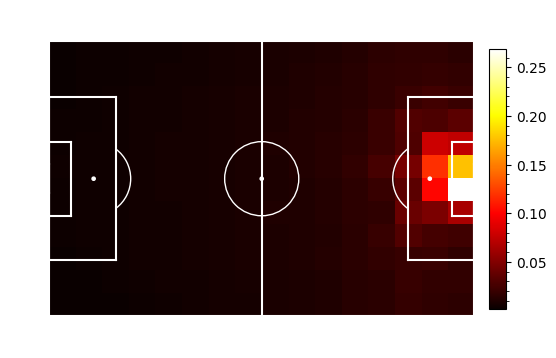

/tmp/ipykernel_761617/1207642098.py:10: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


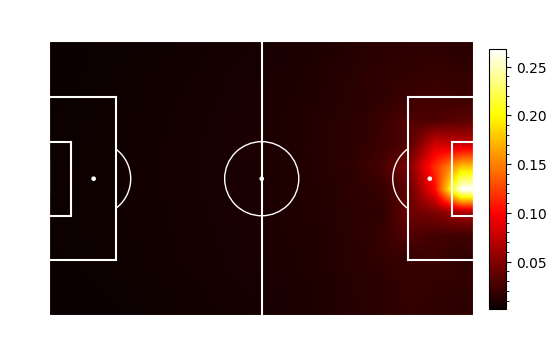

<Axes: >

In [9]:
import matplotsoccer as mps

# Inspect the learned heatmap
mps.heatmap(xTModel.xT, cmap="hot", linecolor="white", cbar="True")

# Inspect the interpolated heatmap used for predictions
interp = xTModel.interpolator()
x = np.linspace(0, 105, 1050)
y = np.linspace(0, 68, 680)
mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")

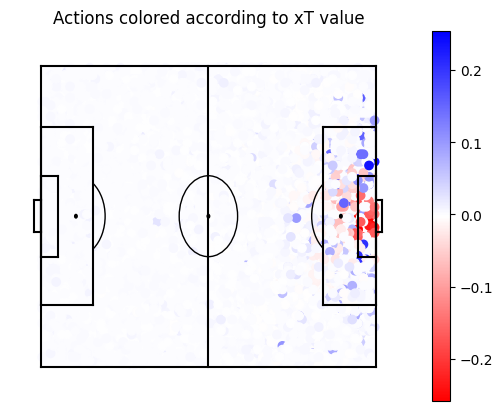

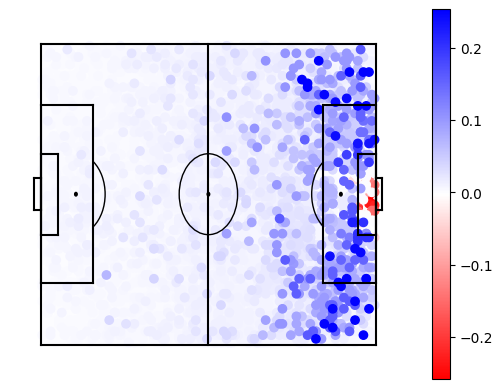

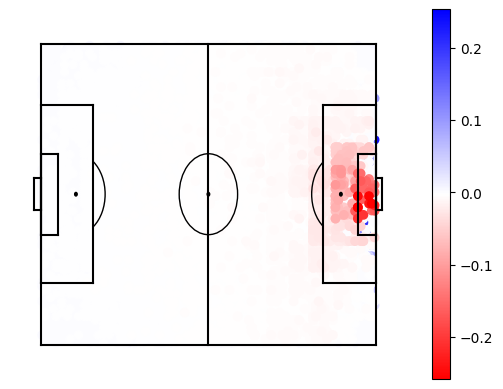

In [10]:
import matplotlib.pyplot as plt

## Visualize xT predictions 
a = mov_actions

# Show scatterplot of actions colored according to xT value
mps.field(show=False)
plt.title("Actions colored according to xT value")
plt.scatter(a.start_x, a.start_y, c=a.xT_value, cmap="bwr_r")
plt.colorbar()
plt.show()

# Show actions with low xT Values on top
a = a.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.scatter(a.start_x, a.start_y, c=a.xT_value, cmap="bwr_r")
plt.colorbar()
plt.show()

# Show actions with high xT Values on top
a = a.sort_values("xT_value", ascending=False)
mps.field(show=False)
plt.scatter(a.start_x, a.start_y, c=a.xT_value, cmap="bwr_r")
plt.colorbar()
plt.show()

In [11]:
import plotly.graph_objects as go

def visualize_surface_plots(xTModel):
    """Visualizes the surface plot of each iteration of the model.

    See https://plot.ly/python/sliders/ and https://karun.in/blog/expected-threat.html#visualizing-xt
    NOTE: y-axis is mirrored in plotly.
    """
    camera = dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=-2.25, y=-1, z=0.5),
    )

    max_z = np.around(xTModel.xT.max() + 0.05, decimals=1)

    layout = go.Layout(
        title="Expected Threat",
        autosize=True,
        width=500,
        height=500,
        margin=dict(l=65, r=50, b=65, t=90),
        scene=dict(
            camera=camera,
            aspectmode="auto",
            xaxis=dict(),
            yaxis=dict(),
            zaxis=dict(autorange=False, range=[0, max_z]),
        ),
    )

    fig = go.Figure(layout=layout)

    for i in xTModel.heatmaps:
        fig.add_trace(go.Surface(z=i))

    # Make last trace visible
    for i in range(len(fig.data) - 1):
        fig.data[i].visible = False
    fig.data[len(fig.data) - 1].visible = True

    # Create and add slider
    steps = []
    for i in range(len(fig.data)):
        step = dict(method="restyle", args=["visible", [False] * len(fig.data)])
        step["args"][1][i] = True  # Toggle i'th trace to "visible"
        steps.append(step)

    sliders = [
        dict(
            active=(len(fig.data) - 1),
            currentvalue={"prefix": "Iteration: "},
            pad={"t": 50},
            steps=steps,
        )
    ]

    fig.update_layout(sliders=sliders)
    fig.show()
    
visualize_surface_plots(xTModel)